In [1]:
from Data_Loader import load_data
from Train2 import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

In [2]:
dtype = torch.FloatTensor
''' Net Settings'''
Hidden_Nodes = 143 ###number of hidden nodes
Out_Nodes = 30 ###number of hidden nodes in the last hidden layer
''' Initialize '''
Initial_Learning_Rate = [0.03, 0.01, 0.001, 0.00075]
L2_Lambda = [0.1, 0.01, 0.005, 0.001]
num_epochs = 3 ###for grid search
Num_EPOCHS = 8 ###for training
###sub-network setup
Dropout_Rate = [0.7, 0.5]

In [3]:
from Data_extraction import data_norm_df, output_df2

print(np.shape(output_df2))


(177, 5)


In [4]:
data_norm_df= data_norm_df.reset_index(drop=True)
output_df2 = output_df2.reset_index(drop=True)


In [5]:
data = pd.concat([data_norm_df,output_df2], axis=1)

def split_indices(n, val_pct1, val_pct2):
	n1 = int(val_pct1*n)
	n2 = int(val_pct2*n)
	idxs = np.random.permutation(n)
	train, val, test = idxs[:n1], idxs[n1:n2], idxs[n2:]
	train.sort(), val.sort(), test.sort()
	return(train, val, test)


# train_index, val_index, test_index = split_indices(len(data),0.6, 0.8)

# data_train = data.iloc[train_index]
# data_val = data.iloc[val_index]
# data_test = data.iloc[test_index]
# x_train, ytime_train, yevent_train, age_train = load_data(data_train, dtype)
# x_valid, ytime_valid, yevent_valid, age_valid = load_data(data_val, dtype)
# x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)

PCA

In [6]:
x, ytime, yevent, age = load_data(data, dtype)
# from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
# pca = PCA(.95)
# pca.fit(x)
# x = pca.transform(x)
# x= torch.from_numpy(x)
# print(x.shape)

In [7]:
from Data_Loader import CustomDataset
batch_size=12
data2 = CustomDataset(x, ytime, yevent, age)
In_Nodes = len(x[0,:]) ###number of genes
# train_loader = DataLoader(data2, batch_size, sampler=train_index)
# val_loader = DataLoader(data2, batch_size, sampler=val_index)

In [8]:
opt_l2_loss = 0
opt_lr_loss = 0
opt_do_loss = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###
opt_c_index_va = 0
opt_c_index_tr = 0

Grid search for the optimal learning rate, regularisation, drop out 

In [9]:
# for l2 in L2_Lambda:
# 	for lr in Initial_Learning_Rate:
# 		for do in Dropout_Rate:
# 			history_train, history_val = trainCox_nnet(data2, \
# 				In_Nodes, Hidden_Nodes, Out_Nodes, \
# 				lr, l2, num_epochs, do, batch_size)
# 			loss_train2 = [k['loss'] for k in history_train[1]]
# 			if loss_train2[-1] =='nan': 
# 				break
# 			elif loss_train2[-1] < opt_loss:
# 				opt_l2_loss = l2
# 				opt_lr_loss = lr
# 				opt_do_loss = do
# 				opt_loss = loss_train2[-1]
# 				# opt_c_index_tr = c_index_tr
# 				# opt_c_index_va = c_index_va
# 			print ("L2: ", l2, "LR: ", lr, "Loss in Validation: ", opt_loss)

In [10]:
opt_l2_loss, opt_lr_loss, opt_do_loss = 0.001, 0.00075, 0.5
print(In_Nodes)
#print(opt_l2_loss, opt_lr_loss, opt_do_loss)

55553


Train the model 

In [11]:
###train Cox-PASNet with optimal hyperparameters using train data, and then evaluate the trained model with test data
###Note that test data are only used to evaluate the trained Cox-nnet
history_train, history_val = trainCox_nnet(data2, \
			In_Nodes, Hidden_Nodes, Out_Nodes, \
			opt_lr_loss, opt_l2_loss, Num_EPOCHS, opt_do_loss, batch_size)
print ("Optimal L2: ", opt_l2_loss, "Optimal LR: ", opt_lr_loss)
# print("C-index in Test: ", c_index_te)

------------fold no---------0----------------------
Epoch [0], loss: 2.0325, c_index: 0.5767
Epoch [1], loss: 1.9881, c_index: 0.5767
Epoch [2], loss: 1.9229, c_index: 0.5767
Epoch [3], loss: 1.8784, c_index: 0.5832
Epoch [4], loss: 1.8672, c_index: 0.5672
Epoch [5], loss: 1.8403, c_index: 0.5800
Epoch [6], loss: 1.8360, c_index: 0.5672
Epoch [7], loss: 1.8165, c_index: 0.6150
Epoch [8], loss: 1.8958, c_index: 0.5513
------------fold no---------1----------------------
Epoch [0], loss: 2.9971, c_index: 0.5091
Epoch [1], loss: 3.0864, c_index: 0.5091
Epoch [2], loss: 1.8010, c_index: 0.5422
Epoch [3], loss: 1.9854, c_index: 0.5206
Epoch [4], loss: 2.8321, c_index: 0.5155
Epoch [5], loss: 2.8092, c_index: 0.5091
Epoch [6], loss: 2.4468, c_index: 0.5342
Epoch [7], loss: 2.4204, c_index: 0.4895
Epoch [8], loss: 2.5469, c_index: 0.4719
------------fold no---------2----------------------
Epoch [0], loss: nan, c_index: 0.0000
Epoch [1], loss: nan, c_index: 0.0000
Epoch [2], loss: nan, c_index:

In [12]:
loss_train_fold0 = [k['loss'] for k in history_train[0]]
loss_val_fold0 = [k['loss'] for k in history_val[0]] 
c_index_train_fold0 = [k['c_index'] for k in history_train[0]]
c_index_val_fold0 = [k['c_index'] for k in history_val[0]]

loss_train_fold1 = [k['loss'] for k in history_train[1]]
loss_val_fold1 = [k['loss'] for k in history_val[1]] 
c_index_train_fold1 = [k['c_index'] for k in history_train[1]]
c_index_val_fold1 = [k['c_index'] for k in history_val[1]]

loss_train_fold2 = [k['loss'] for k in history_train[2]]
loss_val_fold2 = [k['loss'] for k in history_val[2]] 
c_index_train_fold2 = [k['c_index'] for k in history_train[2]]
c_index_val_fold2 = [k['c_index'] for k in history_val[2]]

loss_train_fold3 = [k['loss'] for k in history_train[3]]
loss_val_fold3 = [k['loss'] for k in history_val[3]] 
c_index_train_fold3 = [k['c_index'] for k in history_train[3]]
c_index_val_fold3 = [k['c_index'] for k in history_val[3]]

loss_train_fold4 = [k['loss'] for k in history_train[4]]
loss_val_fold4 = [k['loss'] for k in history_val[4]] 
c_index_train_fold4 = [k['c_index'] for k in history_train[4]]
c_index_val_fold4 = [k['c_index'] for k in history_val[4]]


In [13]:
epoch = np.arange(0,Num_EPOCHS+1)

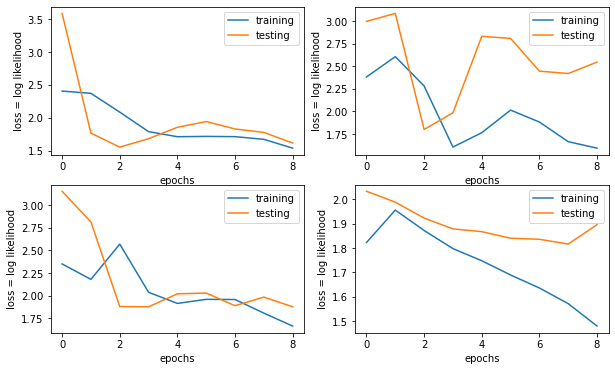

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, loss_train_fold4, label = 'training')
plt.plot(epoch, loss_val_fold4, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, loss_train_fold1, label = 'training')
plt.plot(epoch, loss_val_fold1, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



plt.subplot(223)
plt.plot(epoch, loss_train_fold3, label = 'training')
plt.plot(epoch, loss_val_fold3, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, loss_train_fold0, label = 'training')
plt.plot(epoch, loss_val_fold0, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



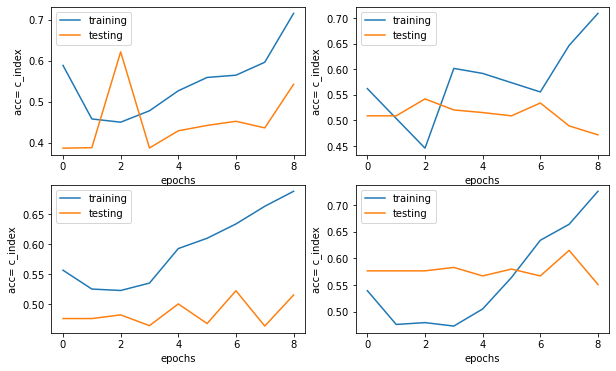

In [23]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, c_index_train_fold4, label = 'training')
plt.plot(epoch, c_index_val_fold4, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, c_index_train_fold1, label = 'training')
plt.plot(epoch, c_index_val_fold1, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(223)
plt.plot(epoch, c_index_train_fold3, label = 'training')
plt.plot(epoch, c_index_val_fold3, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, c_index_train_fold0, label = 'training')
plt.plot(epoch, c_index_val_fold0, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()


In [27]:
#result cross validation

print(np.mean([c_index_val_fold1[1], c_index_val_fold0[1], c_index_val_fold3[1], c_index_val_fold4[1]]))

0.48740652203559875


In [17]:
#avant la cross validation

# loss_train2 = [k['loss'] for k in history_train]
# loss_val2 = [k['loss'] for k in history_val] 
# c_index_tr2 = [k['c_index'] for k in history_train]
# c_index_val2 = [k['c_index'] for k in history_val]

# loss_train2 = [k.detach().numpy() for k in loss_train]
# loss_test2 = [k.detach().numpy() for k in loss_test]
# c_index_tr2 = [k.detach().numpy() for k in c_index_tr]
# c_index_te2 = [k.detach().numpy() for k in c_index_te]
# epoch = np.arange(0,Num_EPOCHS+2,2)

In [18]:
# from Survival_CostFunc_CIndex import R_set, neg_par_log_likelihood, c_index
# from Model2 import Cox_nnet

# net = Cox_nnet(In_Nodes, Hidden_Nodes, Out_Nodes, 0.5)
# net.eval()
# data_test = data.iloc[test_index]
# x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)
# test_pred=net(x_test, age_test)
# eval_loss = []
# eval_cindex=[]
# eval_loss.append(neg_par_log_likelihood(test_pred, ytime_test, yevent_test).view(1,))
# eval_cindex.append(c_index(test_pred, ytime_test, yevent_test))

Data visualisation 

<AxesSubplot:xlabel='vital_status', ylabel='count'>

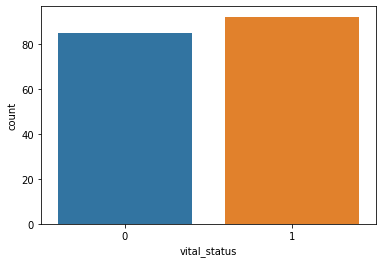

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.countplot(x='vital_status', data=data)

In [20]:
x_df=pd.DataFrame(x, columns = np.arange(len(x[0,:])))
data_cph = pd.concat([x_df,pd.DataFrame({'age': age[:,0], 'yevent': yevent[:,0], 'ytime': ytime[:,0]})], axis=1)
essai = data_cph.drop(data[data_cph.yevent==0].index)
essai2 = data_cph.drop(data_cph[data_cph.yevent==1].index)

C:\Users\anais\AppData\Local\Temp\ipykernel_9068\2735630853.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  essai = data_cph.drop(data[data_cph.yevent==0].index)


KeyError: 'days_to_death'

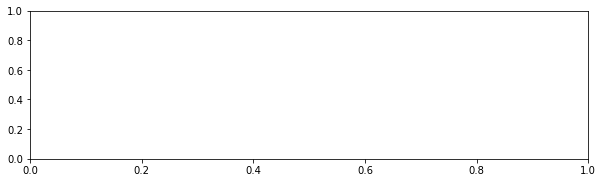

In [21]:
plt.figure(figsize=(10,6))
plt.subplot(211)
sns.distplot(essai['days_to_death'], kde=False, label='dead patients')
plt.xlabel('days_to_death')
plt.legend()
plt.subplot(212)
sns.distplot(essai2['days_to_last_follow_up'], kde=False, label='patients alive')
plt.xlabel('days_to_last_follow_up')
plt.legend()


C:\Users\anais\AppData\Local\Temp\ipykernel_18028\451791981.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  essai = data_cph.drop(data[data_cph.yevent==0].index)
c:\Users\anais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


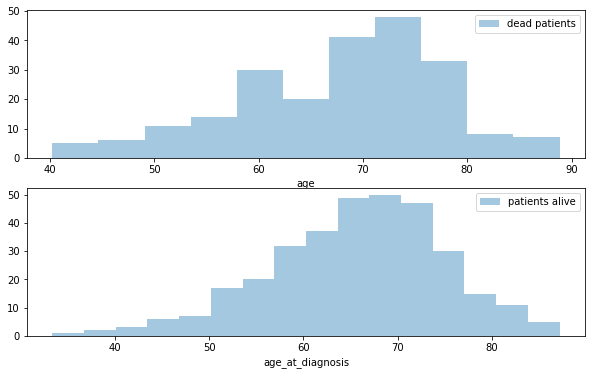

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 



plt.figure(figsize=(10,6))
plt.subplot(211)
sns.distplot(essai['age']/365, kde=False, label='dead patients')
plt.legend()
plt.subplot(212)
sns.distplot(essai2['age']/365, kde=False, label='patients alive')
plt.xlabel('age_at_diagnosis')
plt.legend()


PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Data_Loader import sort_data
x, ytime, yevent, age = sort_data(data)
x = StandardScaler().fit_transform(x)
pca = PCA(.98)
pca.fit(x)
x = pca.transform(x)

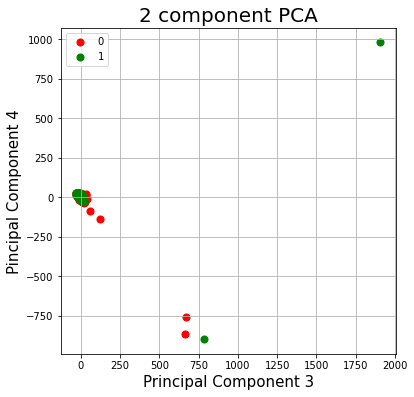

In [ ]:
import matplotlib.pyplot as plt
principalDf = pd.DataFrame(data=x[:,0:2], columns = ['principal component 1', 'principal component 2'])
principalDf['yevent']= yevent
# finalDf = pd.concat([principalDf, yevent2], axis=1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Pincipal Component 4', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0,1]
colors = ['r','g']
for target, color in zip(targets, colors): 
    indicesToKeep = principalDf['yevent']==target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s=50)
ax.legend(targets)
ax.grid()


Data visualisation: Kaplan Meier

In [ ]:
from lifelines import KaplanMeierFitter

<AxesSubplot:xlabel='timeline'>

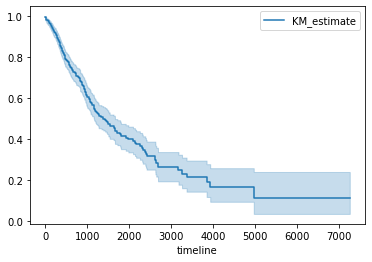

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = ytime, event_observed = yevent)
kmf.plot_survival_function()

CoxPH Analysis 

In [ ]:
from lifelines import CoxPHFitter
from Data_Loader import sort_data
from sklearn.preprocessing import StandardScaler

# x, ytime, yevent, age = sort_data(data)
# x = StandardScaler().fit_transform(x)

cph = CoxPHFitter()
x_df=pd.DataFrame(x, columns = np.arange(len(x[0,:])))
data_cph = pd.concat([x_df,pd.DataFrame({'age': age[:,0], 'yevent': yevent[:,0], 'ytime': ytime[:,0]})], axis=1)



In [ ]:
# cph.fit(data_cph, duration_col = 'ytime', event_col = 'yevent')
# summary = cph.print_summary()
# cph.check_assumptions(data_cph, p_value_threshold = 0.05)

TypeError: title() missing 1 required positional argument: 'label'

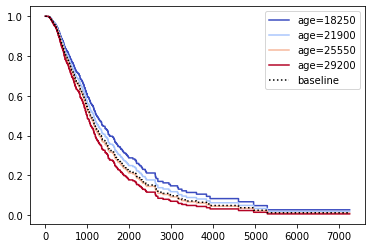

In [ ]:
# cph.plot_partial_effects_on_outcome(covariates = 'age', values = [50*365, 60*365, 70*365, 80*365], cmap = 'coolwarm', label = ['50', '60', '70', '80'])

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

In [ ]:
from sklearn.model_selection import KFold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
c_index_cph = []
for fold,(train_idx,test_idx) in enumerate(kfold.split(data_cph)):
    cph = CoxPHFitter(penalizer=0.1)
    data_train = data_cph.loc[train_idx].reset_index( drop = True )
    data_test  = data_cph.loc[test_idx].reset_index( drop = True )

    # Creating the X, T and E input
    X_train, X_test = data_train.drop(['ytime','yevent'], axis=1).values, data_test.drop(['ytime','yevent'], axis=1).values
    T_train, T_test = data_train['ytime'].values, data_test['ytime'].values
    E_train, E_test = data_train['yevent'].values, data_test['yevent'].values

    cph.fit(data_train, duration_col = 'ytime', event_col = 'yevent')
    Estimate = cph.predict_partial_hazard(X_test)
    E_test2= [bool(k) for k in E_test]
    c_index_cph.append(concordance_index_censored(E_test2, T_test,Estimate))

In [ ]:
print(c_index_cph)
print(np.sum(c_index_cph[k][0] for k in range (5))/5)

[(0.48292883587001234, 1174, 1257, 0, 1), (0.5373665480427047, 1208, 1040, 0, 3), (0.6312056737588653, 1691, 988, 0, 3), (0.48466833541927407, 1549, 1647, 0, 1), (0.6279483756119271, 1411, 836, 0, 0)]
0.5528235537405568


C:\Users\anais\AppData\Local\Temp\ipykernel_20952\1878621565.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(np.sum(c_index_cph[k][0] for k in range (5))/5)


In [ ]:
print(data_cph.head())

            0           1           2          3          4          5  \
0   47.885588  115.564998  100.940894 -49.376928 -99.920459 -32.045329   
1  -49.613442  -72.774106   14.348902 -17.796781  -1.599960   4.021999   
2  146.540942   41.415011  -17.055120  59.297603 -75.364851 -71.300987   
3  -32.082368  -51.369290  -44.825979 -41.058173 -33.626207  19.284864   
4  -79.890303  -51.646540   -7.434863   2.749787   5.309920 -25.664607   

           6          7          8           9  ...       363       364  \
0 -24.634132 -22.959722  14.434477  -21.292606  ...  0.189353  0.394686   
1   0.939073  -4.787979   8.873845    0.391157  ... -4.325699  8.291152   
2 -42.982824 -33.613906 -86.397389  118.173599  ...  0.299909  1.411004   
3   4.989686  51.177271 -21.124082   -0.314374  ...  9.943247  1.099199   
4  16.455170 -21.463067   8.259689    2.524508  ...  5.972015  4.670865   

         365        366        367        368        369      age  yevent  \
0   0.514715   0.712797  -1